In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

data_path = '../raw_data/100k_data.csv'
df_all = pd.read_csv(data_path)
df_all = df_all.dropna()
df_sample = df_all.dropna().sample(10000,random_state=0)

def binary_cat_upvotes(original_df, threshold=30):
    """
    Takes column from df called 'upvotes' and returns df with new column
    'cat_upvotes' which is 1 if upvotes is above threshold, and 0 otherwise.
    """
    df = original_df.copy()
    if 'upvotes' not in original_df.columns:
        raise ValueError("df has no column named 'upvotes'")
    def trans(number):
        if number >= threshold:
            return 1
        else:
            return 0
    df['cat_upvotes'] = df['upvotes'].apply(trans)
    return df

def multi_cat_upvotes(original_df, int_list=[10,100,1000]):
    """
    Takes column from df and returns df with new
    column 'cat_upvotes' based on list passed as an argument
    """
    df = original_df.copy()
    def trans(number):
        for index, integer in enumerate(int_list):
            if number < integer:
                return index
        return len(int_list)
    df['cat_upvotes'] = df['upvotes'].apply(trans)
    return df

def basic(original_df,keep_timestamp=False):
    """
    Transforms 'time_stamp' column from df into individual components 'year',
    'month','day','weekday','hour','minute'
    """
    df = original_df.copy()

    if 'time_stamp' not in df.columns:
        raise ValueError("df has no column named 'time_stamp'")
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], unit='s')

    df['year'] = df.time_stamp.dt.year
    df['month'] = df.time_stamp.dt.month
    df['day'] = df.time_stamp.dt.day
    df['weekday'] = df.time_stamp.dt.weekday
    df['hour'] = df.time_stamp.dt.hour
    df['minute'] = df.time_stamp.dt.minute

    if keep_timestamp is False:
        df = df.drop(columns='time_stamp')
    return df

def cyclize(original_df):
    """
    Transforms columns named 'month','day','hour','minute' into sin and cos
    cyclic values for use with machine learning models
    """
    df = original_df.copy()

    need_list = ['month','day','hour','minute']
    max_dict = {
        'month':12,
        'day': 31,
        'hour': 23,
        'minute': 59
    }

    for column in need_list:
        if column in df.columns:
            def sin_trans(number):
                return math.sin(number * (2. * math.pi / max_dict[column]))
            def cos_trans(number):
                return math.cos(number * (2. * math.pi / max_dict[column]))
            df['sin_' + column] = df[column].apply(sin_trans)
            df['cos_' + column] = df[column].apply(cos_trans)
            df = df.drop(columns=column, axis=1)

    return df

def encode_weekday(original_df, keep_weekday_column=False):
    """
    OneHotEncodes column from df column named 'weekday'
    """
    df = original_df.copy()

    enc = OneHotEncoder(handle_unknown='ignore')
    df_wkdy = pd.DataFrame(enc.fit_transform(df[['weekday']]).toarray())
    df = pd.concat([df.reset_index(), df_wkdy], axis=1)
    df = df.set_index('index')
    if keep_weekday_column==False:
        df = df.drop('weekday', axis=1)
    return df

def transform_timestamp(original_df):
    """
    Takes 'time_stamp' column from df and returns df preprocessed and
    ready for machine learning
    """
    df = original_df.copy()
    df = basic(df)
    df = cyclize(df)
    df = encode_weekday(df)
    if 'year' in df.columns:
        scaler = MinMaxScaler()
        df['year'] = scaler.fit_transform(df[['year']].copy())
    return df

''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

df = df_all[['time_stamp','upvotes']]
df = transform_timestamp(df)
df = binary_cat_upvotes(df, threshold=30)
df = df.drop(columns='upvotes')

df

2022-11-24 14:53:07.881016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,year,sin_month,cos_month,sin_day,cos_day,sin_hour,cos_hour,sin_minute,cos_minute,0,1,2,3,4,5,6,cat_upvotes
index,,,,,,,,,,,,,,,,,
0,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,-0.940700,-0.339239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,-0.638244,-0.769834,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,-0.461093,-0.887352,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,0.263103,-0.964768,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,-0.5,0.866025,0.101168,-0.994869,-0.398401,-0.917211,0.364161,-0.931336,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99260,0.0,0.5,-0.866025,-0.848644,0.528964,-0.519584,0.854419,0.874763,0.484551,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
99262,0.0,0.5,-0.866025,-0.848644,0.528964,-0.730836,0.682553,0.638244,-0.769834,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
99263,0.0,0.5,-0.866025,-0.848644,0.528964,-0.730836,0.682553,0.999646,-0.026621,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [2]:
X = df.drop(columns='cat_upvotes')
y = df['cat_upvotes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

# How many upvoted samples do I have in each split?
train_upvoted = np.sum(y_train[y_train == 1])
val_upvoted = np.sum(y_val[y_val == 1])
test_upvoted = np.sum(y_test[y_test == 1])

print(train_upvoted)
print(val_upvoted)
print(test_upvoted)

print("-"*50)

print(f"{round(train_upvoted / X_train.shape[0] * 100,1)}% samples with 30> upvotes in the train set")
print(f"{round(val_upvoted / X_val.shape[0] * 100,1)}% samples with 30> upvotes in the val set")
print(f"{round(test_upvoted / X_test.shape[0] * 100,1)}% samples with 30> upvotes in the test set")

X_train.shape = (46568, 16)
y_train.shape = (46568,)
X_val.shape = (11642, 16)
y_val.shape = (11642,)
X_test.shape = (14553, 16)
y_test.shape = (14553,)
14165
3562
4451
--------------------------------------------------
30.4% samples with 30> upvotes in the train set
30.6% samples with 30> upvotes in the val set
30.6% samples with 30> upvotes in the test set


In [3]:
X_train.shape[1:]

(16,)

In [4]:
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision

metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(thresholds=0.38),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
    keras.metrics.BinaryAccuracy(threshold=0.38)
]

def init_model():
    input_shape = X_train.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

model = init_model()

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=12,
                    batch_size=16,  
                    shuffle=True)

2022-11-24 14:54:46.591275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/12
2911/2911 [==============================] - 10s 3ms/step - loss: 0.6297 - recall: 0.0230 - precision: 0.3069 - prc: 0.3068 - binary_accuracy: 0.5723 - val_loss: 0.6136 - val_recall: 0.0000e+00 - val_precision: 0.5000 - val_prc: 0.3580 - val_binary_accuracy: 0.6940
Epoch 2/12
2911/2911 [==============================] - 7s 3ms/step - loss: 0.6134 - recall: 1.4119e-04 - precision: 0.3404 - prc: 0.3290 - binary_accuracy: 0.6750 - val_loss: 0.6114 - val_recall: 0.0000e+00 - val_precision: 0.3966 - val_prc: 0.3630 - val_binary_accuracy: 0.6920
Epoch 3/12
2911/2911 [==============================] - 8s 3ms/step - loss: 0.6106 - recall: 8.4716e-04 - precision: 0.3888 - prc: 0.3454 - binary_accuracy: 0.6801 - val_loss: 0.6072 - val_recall: 0.0000e+00 - val_precision: 0.4079 - val_prc: 0.3677 - val_binary_accuracy: 0.6749
Epoch 4/12
2911/2911 [==============================] - 8s 3ms/step - loss: 0.6097 - recall: 5.6477e-04 - precision: 0.3854 - prc: 0.3501 - binary_accuracy: 0.6770

In [5]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

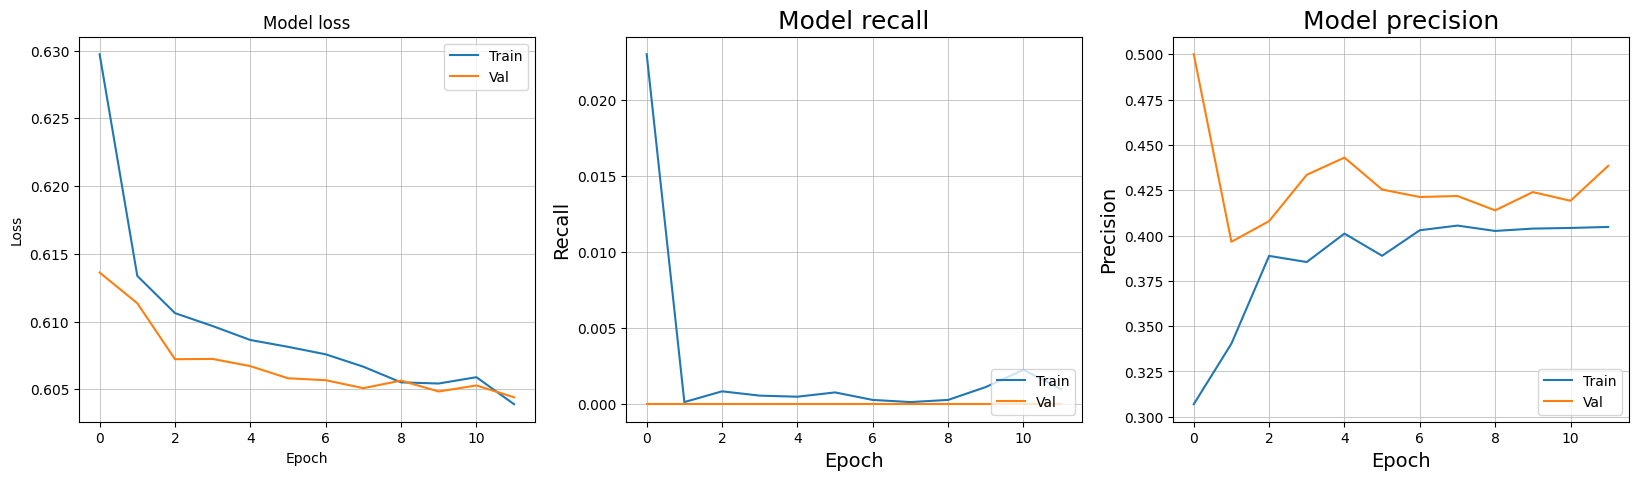

In [6]:
plot_loss_precision_recall_curve(history)

In [7]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

{'loss': 0.6043252944946289,
 'recall': 0.0,
 'precision': 0.44847437739372253,
 'prc': 0.38884425163269043,
 'binary_accuracy': 0.6818525195121765}

In [8]:
y_pred_proba = model.predict(X_test)
threshold = 0.38 # 50% 
y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )
cm = confusion_matrix(y_test,y_pred_binary)
cm

455/455 [==============================] - 1s 1ms/step


array([[9144,  958],
       [3672,  779]])

Text(0.5, 25.722222222222214, 'Predicted label')

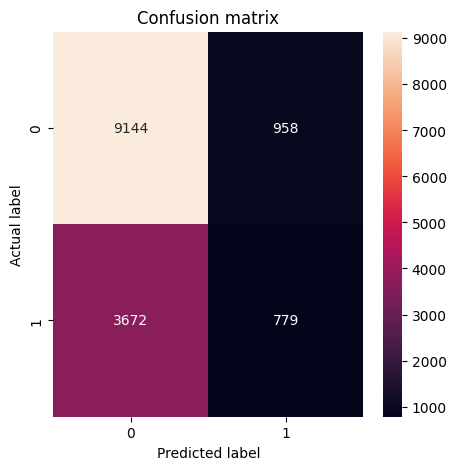

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [10]:
for i in range(35,55):
    threshold = i / 100
    y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )
    cm = confusion_matrix(y_test,y_pred_binary)
    print(f"Threshold: {i/100}")
    print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
    print(f"Accuracy: {round((cm[0,0] + cm[1,1]) / cm.sum() * 100,2)}")
    print(cm)
    print()

Threshold: 0.35
Precision: 41.01
Accuracy: 64.41
[[7714 2388]
 [2791 1660]]

Threshold: 0.36
Precision: 41.83
Accuracy: 65.7
[[8179 1923]
 [3068 1383]]

Threshold: 0.37
Precision: 43.82
Accuracy: 67.35
[[8733 1369]
 [3383 1068]]

Threshold: 0.38
Precision: 44.85
Accuracy: 68.19
[[9144  958]
 [3672  779]]

Threshold: 0.39
Precision: 50.0
Accuracy: 69.42
[[10030    72]
 [ 4379    72]]

Threshold: 0.4
Precision: nan
Accuracy: 69.42
[[10102     0]
 [ 4451     0]]

Threshold: 0.41
Precision: nan
Accuracy: 69.42
[[10102     0]
 [ 4451     0]]

Threshold: 0.42
Precision: nan
Accuracy: 69.42
[[10102     0]
 [ 4451     0]]

Threshold: 0.43
Precision: nan
Accuracy: 69.42
[[10102     0]
 [ 4451     0]]

Threshold: 0.44
Precision: nan
Accuracy: 69.42
[[10102     0]
 [ 4451     0]]

Threshold: 0.45
Precision: nan
Accuracy: 69.42
[[10102     0]
 [ 4451     0]]

Threshold: 0.46
Precision: nan
Accuracy: 69.42
[[10102     0]
 [ 4451     0]]

Threshold: 0.47
Precision: nan
Accuracy: 69.42
[[10102     0]

/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_82326/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_82326/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_82326/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_82326/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum() * 100,2)}")
/var/folders/vb/t35ftt3d30b0gf_9v37z7st80000gn/T/ipykernel_82326/94525836.py:6: RuntimeWarning: invalid value encountered in long_scalars
  print(f"Precision: {round(cm[1,1] / cm[0:,1].sum

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

In [ ]:
y_pred_proba = model.predict(X_test)
threshold = 0.38 # 50% 
y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )
cm = confusion_matrix(y_test,y_pred_binary)
cm
print(classification_report(y_test,y_pred_binary))

In [24]:
df_test = pd.DataFrame({'time_stamp':[111]})
df_test

,time_stamp
0,111


In [35]:
df_test['time_stamp'] = pd.to_datetime(df_test['time_stamp'], unit='s')
df_test

,time_stamp
0,1970-01-01 00:01:51


In [33]:
X_train.columns

Index([      'year',  'sin_month',  'cos_month',    'sin_day',    'cos_day',
         'sin_hour',   'cos_hour', 'sin_minute', 'cos_minute',            0,
                  1,            2,            3,            4,            5,
                  6],
      dtype='object')

In [34]:
X_train['year'].unique()

array([1. , 0.4, 0.8, 0.2, 0. , 0.6])

In [36]:
import pickle
filename = 'timestamp_model.pickle'

In [38]:
model.save('timestamp_model.pickle')

INFO:tensorflow:Assets written to: timestamp_model.pickle/assets


INFO:tensorflow:Assets written to: timestamp_model.pickle/assets
